This task is all about to implement three models to predict the diabetes outcome in the dataset.

# **Importing Related Libraries**

these are the llibraries that I will be used throughout the project.

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score

# **Get the Dataset**

In [2]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
path="/content/drive/My Drive/ML PERSONAL/dataset/diabetes.csv"
diaDF=pd.read_csv(path)

## **Take a Quick Look at the Data Structure**

In [3]:
#check the info of the dataset
diaDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
diaDF.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diaDF.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
diaDF['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


The target class "Outcome" has imbalanced classes.  stratified sampling will be used to help the model learn from both classes effectively and avoids biasing the results toward the majority class.

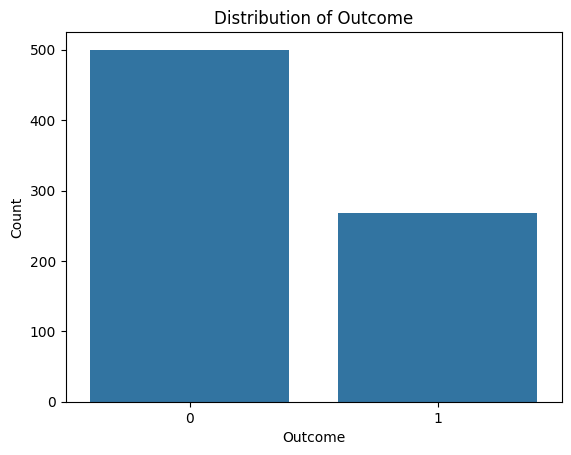

In [7]:
sns.countplot(x='Outcome', data=diaDF)
plt.title('Distribution of Outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

In here, Normal sampling may lead to one of the classes being underrepresented, especially the minority class. Thus, Stratified sampling is used to ensures that both classes are represented in the training and testing sets in the same proportion as the original data.





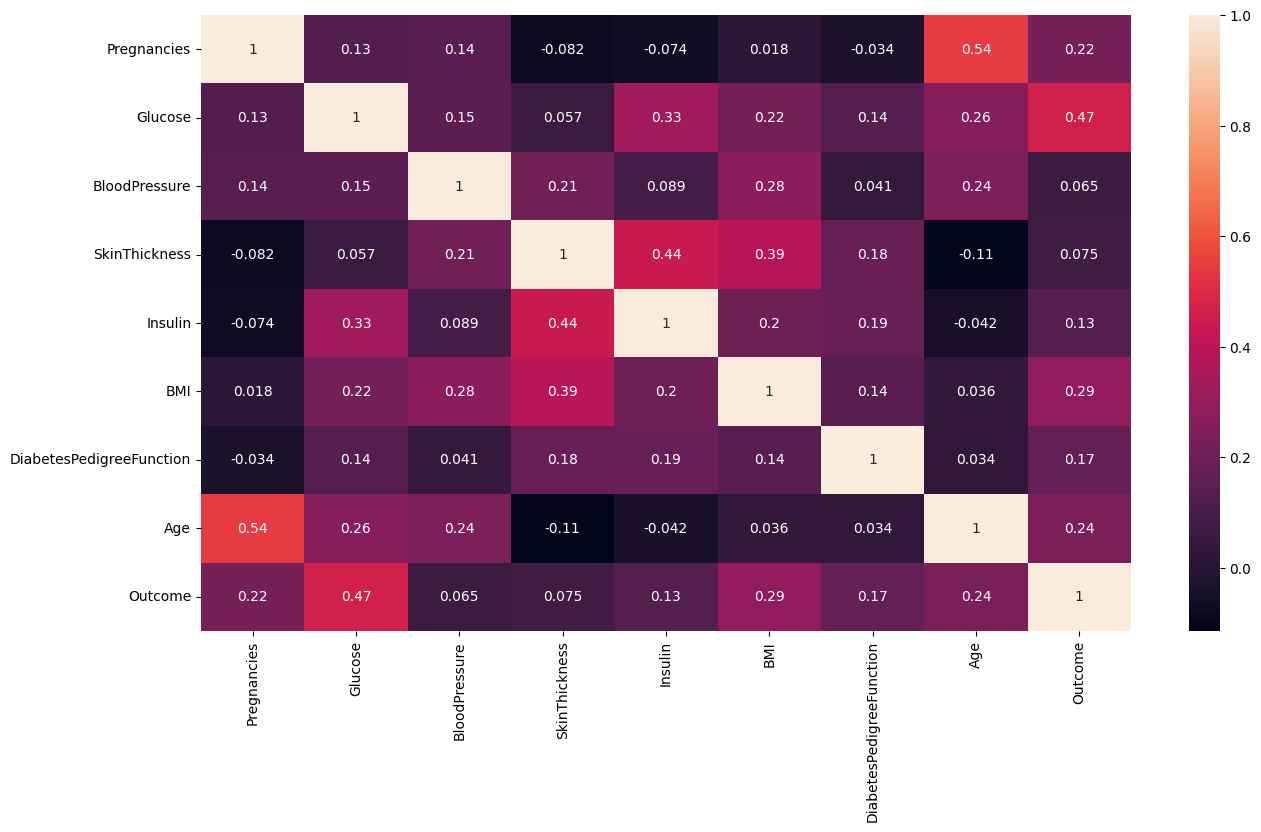

In [8]:
plt.figure(figsize=(15,8))
sns.heatmap(diaDF.corr(),annot=True)
plt.show()

The attribute with the highest correlation to the target column (Outcome) is Age (correlation: 0.55), followed by Glucose (correlation: 0.47). Both could be used for stratified sampling.

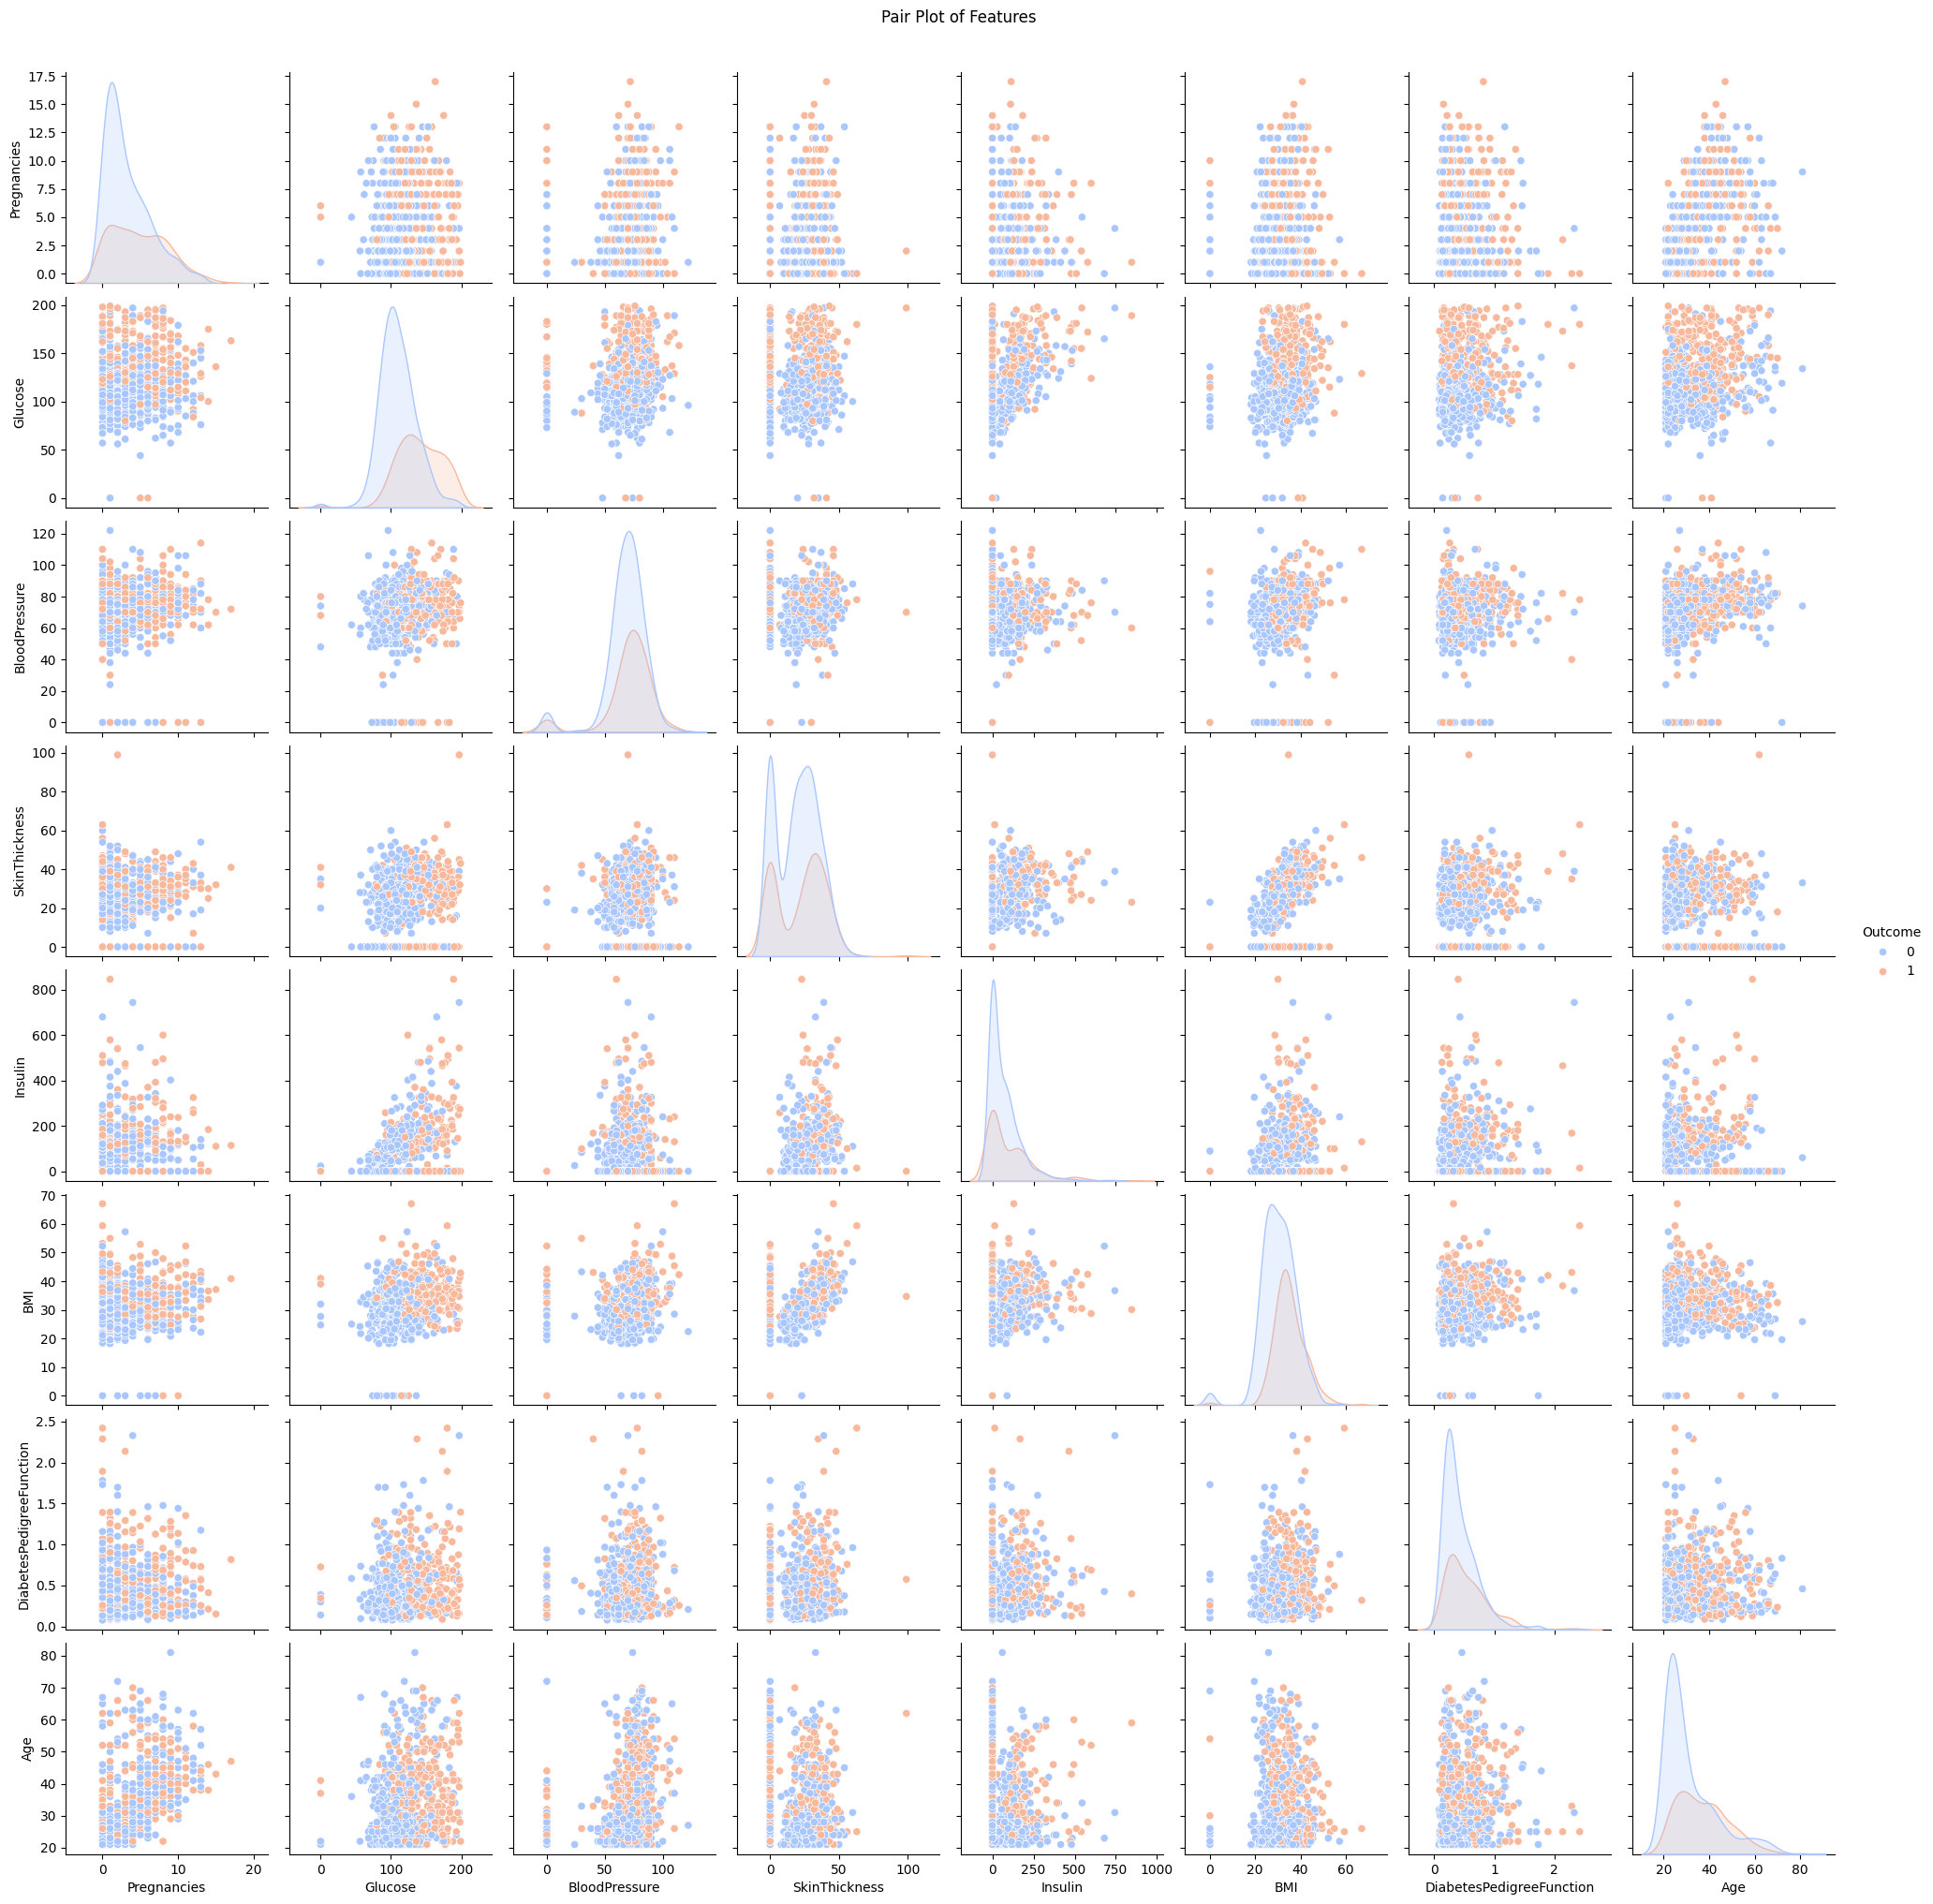

In [9]:
# Pair plot for relationships between features
sns.pairplot(diaDF, hue='Outcome', palette="coolwarm")
plt.suptitle("Pair Plot of Features", y=1.02)
plt.show()

## **Create a test set and training set using stratified sampling**

In [10]:
# Group ages into simpler categories based on typical ranges
# Age bins: 0-30 (1), 31-40 (2), 41-50 (3), 51+ (4)
diaDF['age_bins'] = pd.cut(
    diaDF['Age'],
    bins=[0, 30, 40, 50, 100],  # Define age ranges
    labels=[1, 2, 3, 4]         # Assign labels to each age group
)

In [11]:
# Use StratifiedShuffleSplit to ensure stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(diaDF, diaDF['age_bins']):
    strat_train_set = diaDF.loc[train_index]
    strat_test_set = diaDF.loc[test_index]

In [12]:
# Remove the 'age_bins' column from the datasets
strat_train_set = strat_train_set.drop(columns=['age_bins'])
strat_test_set = strat_test_set.drop(columns=['age_bins'])

In [13]:
# Print results
print(f"Training set shape: {strat_train_set.shape}")
print(f"Test set shape: {strat_test_set.shape}")

Training set shape: (614, 9)
Test set shape: (154, 9)


# **3. DATA PREPORCESSING**

## **EDA**

In [14]:
strat_train_set_copy = strat_train_set.copy()

### Looking for Missing Values

In [15]:
# Dynamically identify columns where 0 should be treated as missing
columns_to_clean = [
    col for col in strat_train_set_copy.columns
    if col not in ['Pregnancies', 'Outcome']  # Avoid logical columns
]

In [16]:
# Replace zeros with NaN in the identified columns for strat_train_set
strat_train_set_copy[columns_to_clean] = strat_train_set_copy[columns_to_clean].replace(0, np.nan)

In [17]:
# Check for missing values in the dataset
missing_values = strat_train_set_copy.isnull().sum()

# Display the missing values count for each column
print("Missing Values in Each Column:")
print(missing_values)


Missing Values in Each Column:
Pregnancies                   0
Glucose                       4
BloodPressure                28
SkinThickness               192
Insulin                     305
BMI                          10
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [18]:
100* missing_values / len(strat_train_set_copy)

,0
Pregnancies,0.000000
Glucose,0.651466
BloodPressure,4.560261
SkinThickness,31.270358
Insulin,49.674267
BMI,1.628664
DiabetesPedigreeFunction,0.000000
Age,0.000000
Outcome,0.000000


In [19]:
def percent_missing(df):
  percent_nan = 100* df.isnull().sum() /len(strat_train_set_copy)
  percent_nan = percent_nan[percent_nan>0].sort_values()
  return percent_nan

In [20]:
percent_nan = percent_missing(strat_train_set_copy)

<ipython-input-21-efadb92a0566>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percent_nan.index,y=percent_nan, palette="coolwarm")


Text(0.5, 0, 'Columns')

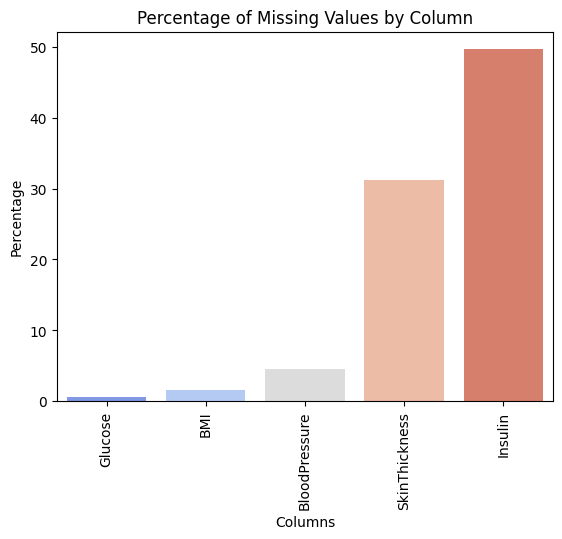

In [21]:
sns.barplot(x=percent_nan.index,y=percent_nan, palette="coolwarm")
plt.xticks(rotation=90);
plt.title("Percentage of Missing Values by Column")
plt.ylabel("Percentage")
plt.xlabel("Columns")

### Looking for Outliers

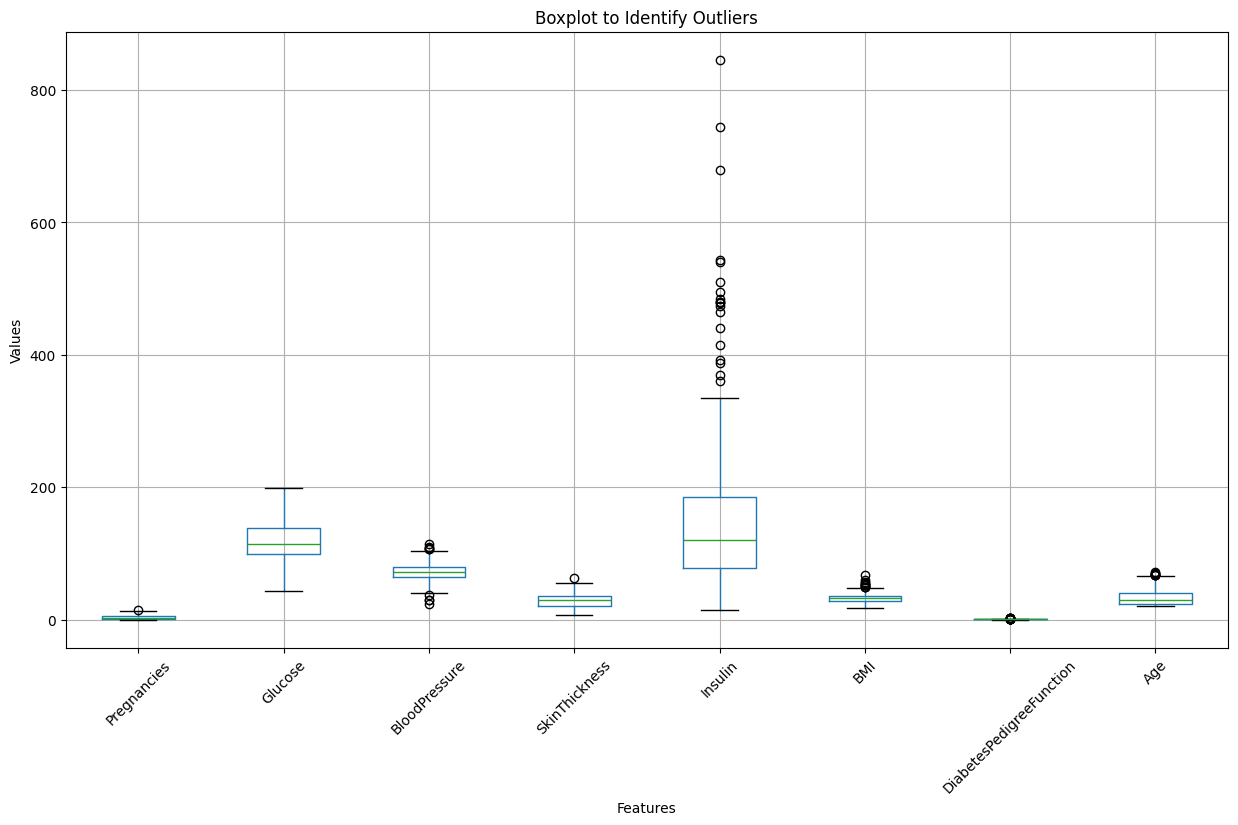

In [22]:
numerical_columns = [
    col for col in strat_train_set_copy.columns if col not in ["Outcome"]
]

plt.figure(figsize=(15, 8))
strat_train_set_copy[numerical_columns].boxplot()
plt.title("Boxplot to Identify Outliers")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45)  #
plt.show()

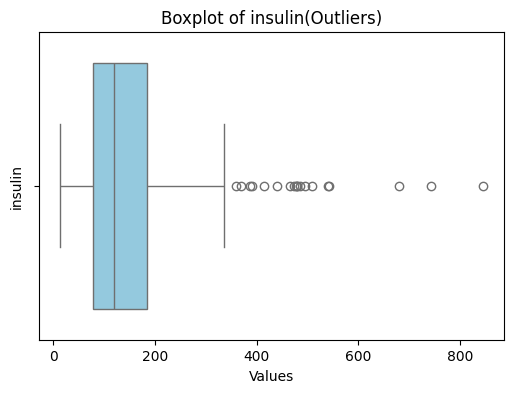

In [23]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=strat_train_set_copy['Insulin'], color="skyblue")
plt.title(f"Boxplot of insulin(Outliers)")
plt.ylabel('insulin')
plt.xlabel('Values')
plt.show()

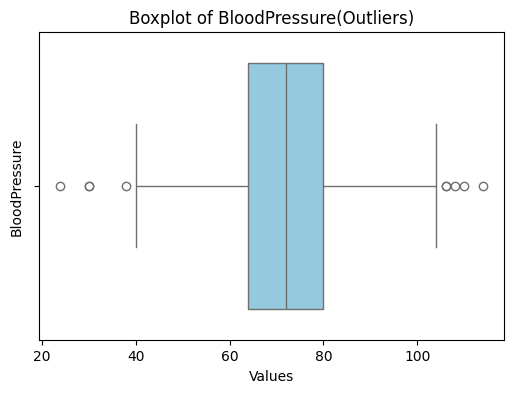

In [24]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=strat_train_set_copy['BloodPressure'], color="skyblue")
plt.title(f"Boxplot of BloodPressure(Outliers)")
plt.ylabel('BloodPressure')
plt.xlabel('Values')
plt.show()

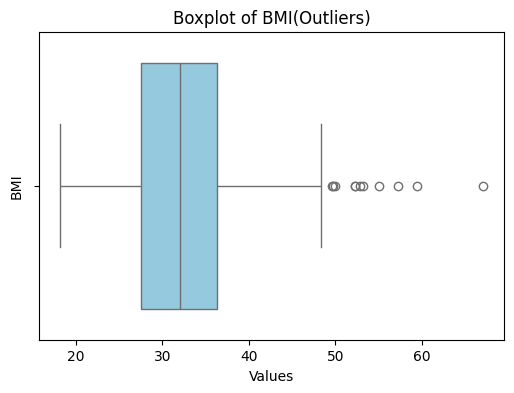

In [25]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=strat_train_set_copy['BMI'], color="skyblue")
plt.title(f"Boxplot of BMI(Outliers)")
plt.ylabel('BMI')
plt.xlabel('Values')
plt.show()

### Looking for Correlations

In [26]:
# Calculate the correlation matrix
correlation_matrix = strat_train_set_copy.corr()


In [27]:
# Sort features by their correlation with the target variable 'Outcome'

target_correlation = correlation_matrix['Outcome'].sort_values(ascending=False)
print("Correlation with Outcome:\n", target_correlation)

Correlation with Outcome:
 Outcome                     1.000000
Glucose                     0.492918
Insulin                     0.309675
BMI                         0.302913
SkinThickness               0.265498
Age                         0.234482
Pregnancies                 0.221473
DiabetesPedigreeFunction    0.163462
BloodPressure               0.163021
Name: Outcome, dtype: float64


## **Data Cleaning**

### Handling missing values

Since we noticed the missing values ,we will replace with the median of each column.

We all know that `Pregnancies` column should not be cleaned or modified as 0 in Pregnancies is valid and it indicates someone has not been pregnant.


Apart from the pregnancies column and the target class, we will impute the missing values with the median.

In [28]:


# Use SimpleImputer to fill missing values with the median
imputer = SimpleImputer(strategy='median')
strat_train_set[columns_to_clean] = imputer.fit_transform(strat_train_set[columns_to_clean])

In [29]:
# Check the cleaned training data
print("Columns cleaned dynamically:", columns_to_clean)
print("Preview of cleaned strat_train_set:")
strat_train_set.head()

Columns cleaned dynamically: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Preview of cleaned strat_train_set:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
468,8,120.0,0.0,0.0,0.0,30.0,0.183,38.0,1
129,0,105.0,84.0,0.0,0.0,27.9,0.741,62.0,1
264,4,123.0,62.0,0.0,0.0,32.0,0.226,35.0,1
379,0,93.0,100.0,39.0,72.0,43.4,1.021,35.0,0
619,0,119.0,0.0,0.0,0.0,32.4,0.141,24.0,1


### Handling outliers

let's detect our outliers first

In [31]:
# Function to detect outliers using the IQR method
def detect_outliers(df, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outlier indices
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices[col] = outliers.tolist()

    return outlier_indices

# Select numerical columns (exclude 'Outcome')
numerical_columns = [
    col for col in strat_train_set.columns if col not in ["Outcome"]
]

# Detect outliers
outliers = detect_outliers(strat_train_set, numerical_columns)

# Display outliers for each column
print("Detected Outliers:")
for column, indices in outliers.items():
    print(f"{column}: {len(indices)} outliers")

Detected Outliers:
Pregnancies: 1 outliers
Glucose: 4 outliers
BloodPressure: 37 outliers
SkinThickness: 0 outliers
Insulin: 27 outliers
BMI: 21 outliers
DiabetesPedigreeFunction: 21 outliers
Age: 8 outliers


Now, we will analyze a few outliers in detail to understand if they represent data errors or legitimate extreme values.To do so, We need to decide if we will remove or cap them, or transform the data.

In this specific case, removing outliers could potentially bias the model towards predictions.

Therefore, we decided to keep the outliers for now.

## Feture Scaling

In [30]:
# Select numerical columns to scale (exclude 'Outcome')
numerical_columns = [col for col in strat_train_set.columns if col != "Outcome"]

# Apply StandardScaler for standardization
scaler = RobustScaler()
strat_train_set[numerical_columns] = scaler.fit_transform(strat_train_set[numerical_columns])

In [31]:
# Check scaled data
print("Training set after feature scaling:")
strat_train_set.head()

Training set after feature scaling:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
468,1.0,0.125,-4.500,-0.68750,-0.129167,-0.227920,-0.540611,0.529412,1
129,-0.6,-0.250,0.750,-0.68750,-0.129167,-0.467236,0.909682,1.941176,1
264,0.2,0.200,-0.625,-0.68750,-0.129167,0.000000,-0.428850,0.352941,1
379,-0.6,-0.550,1.750,0.53125,0.470833,1.299145,1.637427,0.352941,0
619,-0.6,0.100,-4.500,-0.68750,-0.129167,0.045584,-0.649773,-0.294118,1


In [32]:
# Apply the same scaler to strat_test_set
strat_test_set[numerical_columns] = scaler.transform(strat_test_set[numerical_columns])

# **Model Development**

## **Building a model**

To ensure that the model learns to predict the class based on the features alone, without any influence from the target variable during training, I will separate the target variable class is separated from the features in both the training and test sets.

In [33]:
# Split strat_train_set into X_train and y_train
X_train = strat_train_set.drop(columns=["Outcome"])  # Drop target column for features
y_train = strat_train_set["Outcome"]  # Target column

In [34]:
# Split into X_test and y_test
X_test = strat_test_set.drop(columns=["Outcome"])
y_test = strat_test_set["Outcome"]

In [35]:
# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (614, 8), y_train shape: (614,)
X_test shape: (154, 8), y_test shape: (154,)


**SVM**

In [36]:
svm_model = SVC(C=100)
svm_model.fit(X_train, y_train)

SVC(C=100)

**Logistic Regression**

In [37]:
# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

**Decision Tree**

In [38]:
 #Decision Tree
tree_model = DecisionTreeClassifier(max_depth=7)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

**kNN**

In [39]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

## **Training a model**


we will write a function that can generate confusion matrix and classfication report

In [40]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Display the results
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return accuracy

**SVM**

Support Vector Classifier Accuracy: 0.71
Support Vector Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       103
           1       0.56      0.63      0.59        51

    accuracy                           0.71       154
   macro avg       0.68      0.69      0.69       154
weighted avg       0.72      0.71      0.72       154



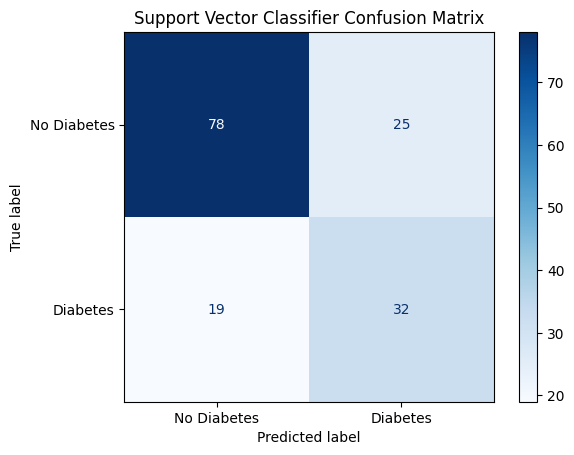

0.7142857142857143

In [41]:
svc_accuracy =evaluate_model(svm_model, X_test, y_test, 'Support Vector Classifier')
svc_accuracy

**Logistic Regression**

Logistic Regression Accuracy: 0.78
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       103
           1       0.66      0.69      0.67        51

    accuracy                           0.78       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.78      0.78       154



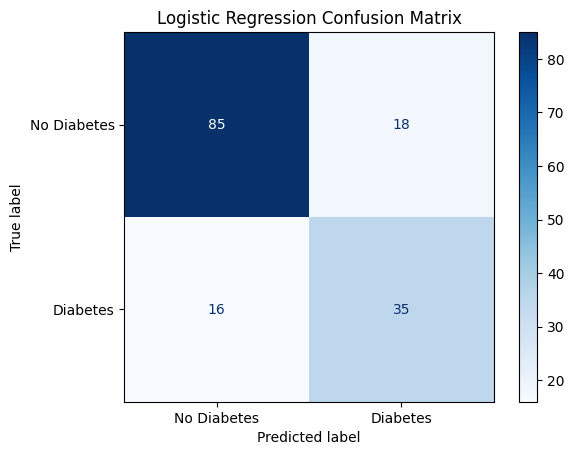

0.7792207792207793

In [42]:
log_reg_accuracy =evaluate_model(logistic_model, X_test, y_test, 'Logistic Regression')
log_reg_accuracy

**Decision Tree**

Decision Tree Accuracy: 0.73
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       103
           1       0.58      0.63      0.60        51

    accuracy                           0.73       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



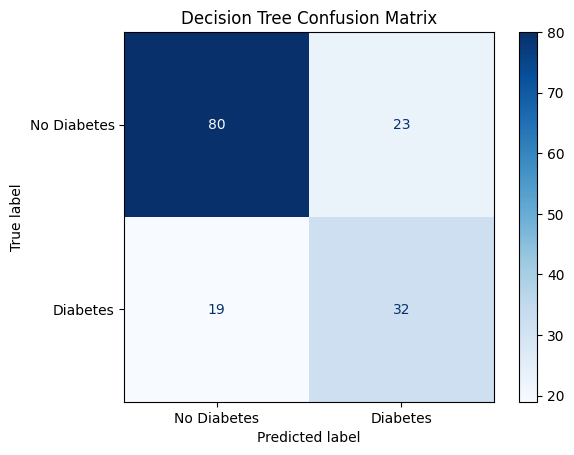

0.7272727272727273

In [43]:
dt_accuracy =evaluate_model(tree_model, X_test, y_test, 'Decision Tree')
dt_accuracy

**KNN**

kNN Accuracy: 0.71
kNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       103
           1       0.55      0.61      0.58        51

    accuracy                           0.71       154
   macro avg       0.67      0.68      0.68       154
weighted avg       0.72      0.71      0.71       154



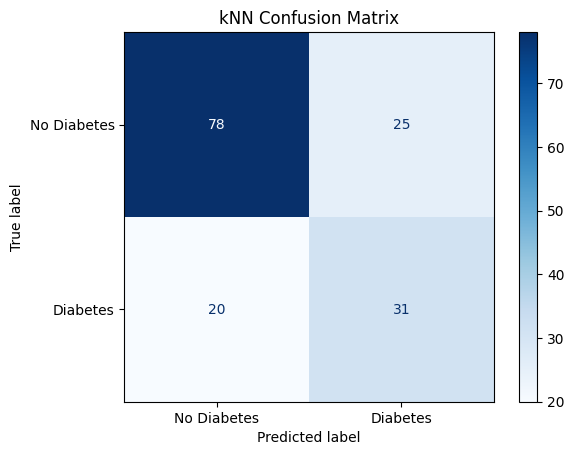

0.7077922077922078

In [44]:
kNN_accuracy =evaluate_model(knn_model, X_test, y_test, 'kNN')
kNN_accuracy

#**Hyperparameter tuning**

**SVM**

In [45]:
# Define the parameter grid
param_grid = {
    'C': [ 1, 10, 100, 1000],
    'gamma': [ 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
    }

# Perform Grid Search with 5-fold cross-validation
svm_grid = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy', verbose=2)
#retrain the model
svm_grid.fit(X_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters for SVM:", svm_grid.best_params_)
print("Best Cross-Validation Accuracy for SVM:", svm_grid.best_score_)

# Use the best model for predictions
best_svm_model = svm_grid.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, 

Support Vector Classifier Accuracy: 0.78
Support Vector Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       103
           1       0.68      0.63      0.65        51

    accuracy                           0.78       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.78      0.78      0.78       154



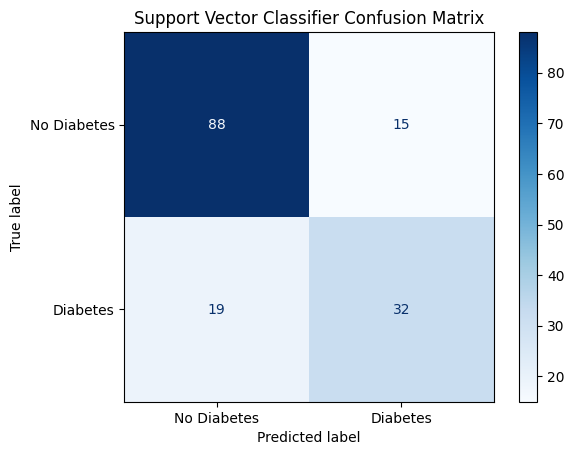

0.7792207792207793

In [46]:
svm_final=evaluate_model(best_svm_model, X_test, y_test, 'Support Vector Classifier')
svm_final

In [53]:
# Training set accuracy
svm_train_accuracy = best_svm_model.score(X_train, y_train)

# Test set accuracy
svm_test_accuracy = best_svm_model.score(X_test, y_test)

print("Training Accuracy:", svm_train_accuracy)
print("Test Accuracy:", svm_test_accuracy)

# Check for overfitting or underfitting
if svm_train_accuracy > svm_test_accuracy + 0.1:
    print("The model is overfitting.")
elif svm_train_accuracy < 0.7 and svm_test_accuracy < 0.7:
    print("The model is underfitting.")
else:
    print("The model has a good balance of fit.")


Training Accuracy: 0.7899022801302932
Test Accuracy: 0.7792207792207793
The model has a good balance of fit.


**kNN**

In [54]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
}
# Perform GridSearchCV with 5-fold cross-validation
knn_grid = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
knn_grid.fit(X_train, y_train) #retrain the model

# Get the best parameters and best model
print("Best Parameters for kNN:", knn_grid.best_params_)
print("Best Cross-Validation Accuracy for kNN:", knn_grid.best_score_)

# Use the best model for predictions
best_knn_model = knn_grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for kNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best Cross-Validation Accuracy for kNN: 0.7540983606557375


kNN Accuracy: 0.76
kNN Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       103
           1       0.65      0.59      0.62        51

    accuracy                           0.76       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.76      0.76       154



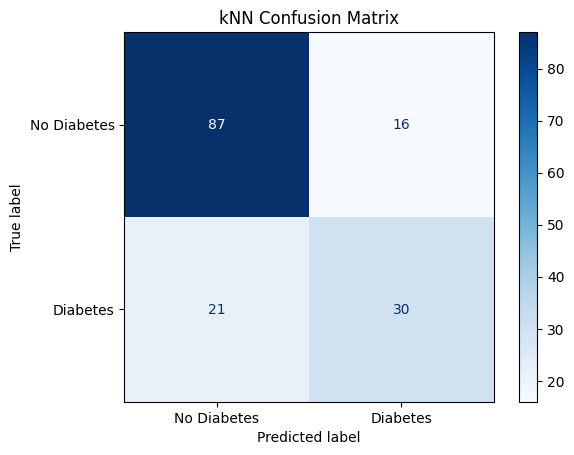

0.7597402597402597

In [55]:
knn_final=evaluate_model(best_knn_model, X_test, y_test, 'kNN')
knn_final

In [60]:
# Training set accuracy
knn_train_accuracy = best_knn_model.score(X_train, y_train)

# Test set accuracy
knn_test_accuracy = best_knn_model.score(X_test, y_test)

print("Training Accuracy:", knn_train_accuracy)
print("Test Accuracy:", knn_test_accuracy)

# Check for overfitting or underfitting
if knn_train_accuracy > knn_test_accuracy + 0.1:
    print("The model is overfitting.")
elif knn_train_accuracy < 0.7 and knn_test_accuracy < 0.7:
    print("The model is underfitting.")
else:
    print("The model has a good balance of fit.")

Training Accuracy: 0.7980456026058632
Test Accuracy: 0.7597402597402597
The model has a good balance of fit.


**Decision Tree**

In [67]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],                # Splitting criterion
    'max_depth': [3, 5, 7, 10],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]               # Minimum samples required to be a leaf node
}

# Perform GridSearchCV with 5-fold cross-validation
dt_grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Get the best parameters and the best model
print("Best Parameters for Decision Tree:", dt_grid.best_params_)
print("Best Cross-Validation Accuracy for Decision Tree:", dt_grid.best_score_)

# Use the best model for predictions
best_dt_model = dt_grid.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validation Accuracy for Decision Tree: 0.7313208050113288


Decision Tree Accuracy: 0.68
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       103
           1       0.52      0.57      0.54        51

    accuracy                           0.68       154
   macro avg       0.65      0.65      0.65       154
weighted avg       0.69      0.68      0.69       154



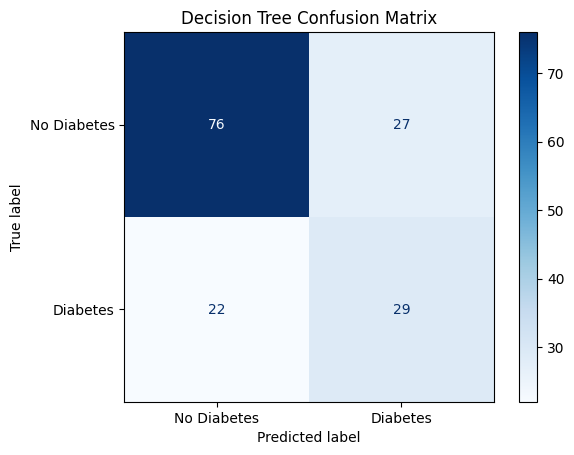

0.6818181818181818

In [68]:
dt_final=evaluate_model(best_dt_model, X_test, y_test, 'Decision Tree')
dt_final

In [70]:
# Training set accuracy
dt_train_accuracy = best_dt_model.score(X_train, y_train)

# Test set accuracy
dt_test_accuracy = best_dt_model.score(X_test, y_test)

print("Training Accuracy:", dt_train_accuracy)
print("Test Accuracy:", dt_test_accuracy)

# Check for overfitting or underfitting
if dt_train_accuracy > dt_test_accuracy + 0.1:
    print("The model is overfitting.")
elif dt_train_accuracy < 0.7 and dt_test_accuracy < 0.7:
    print("The model is underfitting.")
else:
    print("The model has a good balance of fit.")

Training Accuracy: 0.8387622149837134
Test Accuracy: 0.6818181818181818
The model is overfitting.


**Logisitic Regression**

In [71]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization techniques
    'C': [0.01, 0.1, 1, 10, 100],                # Regularization strength
    'solver': ['liblinear', 'saga'],             # Solvers
    'max_iter': [100, 200, 500]                  # Maximum iterations
}

# Perform Grid Search with 5-fold cross-validation
log_reg_grid = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model to the training data
log_reg_grid.fit(X_train, y_train)

# Get the best parameters and the best model
print("Best Parameters for Logistic Regression:", log_reg_grid.best_params_)
print("Best Cross-Validation Accuracy for Logistic Regression:", log_reg_grid.best_score_)

# Use the best model for predictions
best_log_reg_model = log_reg_grid.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters for Logistic Regression: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Accuracy for Logistic Regression: 0.7687991470078634


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
225 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

Logistic Regression Accuracy: 0.77
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       103
           1       0.65      0.69      0.67        51

    accuracy                           0.77       154
   macro avg       0.74      0.75      0.75       154
weighted avg       0.78      0.77      0.77       154



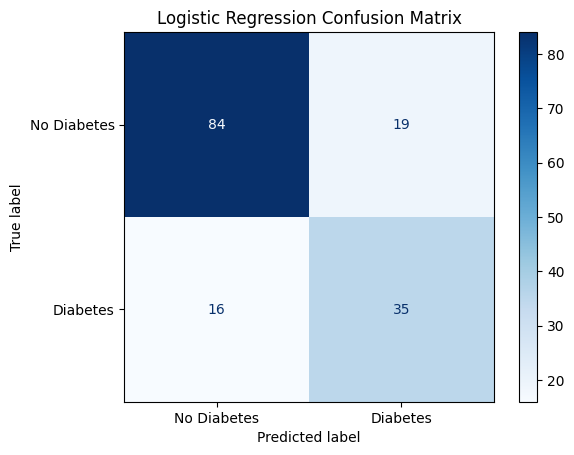

In [72]:
# Evaluate the tuned model on the test set
log_reg_final_accuracy = evaluate_model(best_log_reg_model, X_test, y_test, 'Logistic Regression')

In [74]:
# Training set accuracy
log_train_accuracy = best_log_reg_model.score(X_train, y_train)

# Test set accuracy
log_test_accuracy = best_log_reg_model.score(X_test, y_test)

print("Training Accuracy:", log_train_accuracy)
print("Test Accuracy:", log_test_accuracy)

# Check for overfitting or underfitting
if log_train_accuracy > log_test_accuracy + 0.1:
    print("The model is overfitting.")
elif log_train_accuracy < 0.7 and log_test_accuracy < 0.7:
    print("The model is underfitting.")
else:
    print("The model has a good balance of fit.")



Training Accuracy: 0.7817589576547231
Test Accuracy: 0.7727272727272727
The model has a good balance of fit.


Since DT overfits, its high training accuracy does not translate to reliable test performance. Comparing it with models that generalize better (KNN, SVM, and Logistic Regression) ensures a fair evaluation.

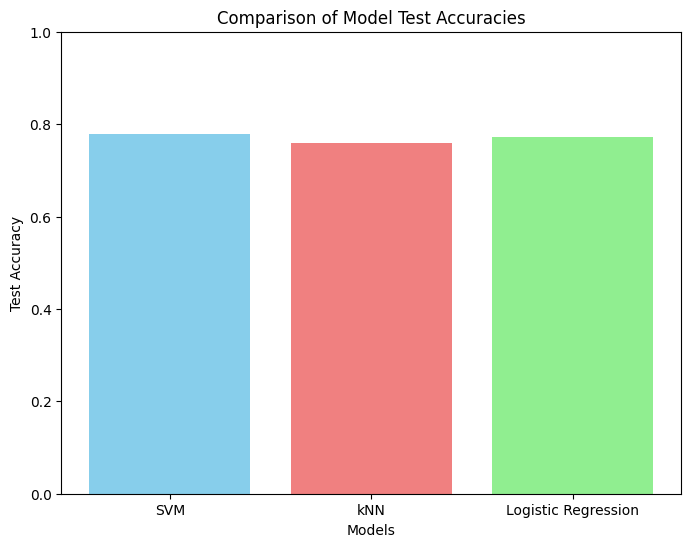

In [75]:
models = ['SVM', 'kNN', 'Logistic Regression']
accuracies = [svm_test_accuracy, knn_test_accuracy, log_test_accuracy]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Model Test Accuracies")
plt.ylim(0, 1)
plt.show()


#**Model Prediction**

We can also see comparison of the actual and predicted values for all three models as well.

In [80]:
# Get predictions from the models
svm_predictions = best_svm_model.predict(X_test)
knn_predictions = best_knn_model.predict(X_test)
log_predictions = best_log_reg_model.predict(X_test)

y_test_series = pd.Series(y_test, index=X_test.index, name="Actual")

# Create a DataFrame to compare predictions
comparison_df = pd.DataFrame({
    "Actual": y_test_series,
    "SVM Prediction": svm_predictions,
    "KNN Prediction": knn_predictions,
    "Logistic Regression Prediction": log_predictions
})

print(comparison_df.head(10))

     Actual  SVM Prediction  KNN Prediction  Logistic Regression Prediction
501       0               0               0                               0
109       1               0               0                               0
744       0               1               1                               1
222       0               0               0                               0
383       0               0               0                               0
43        1               1               1                               1
112       0               0               0                               0
55        0               0               0                               0
319       1               1               0                               1
281       0               1               0                               1


# **User Input Interface for Diabetes Prediction**

In [81]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np

In [84]:
# Define input widgets for each feature based on the dataset ranges
pregnancies = widgets.IntSlider(description="Pregnancies:", min=0, max=17, step=1, value=1)
glucose = widgets.IntSlider(description="Glucose:", min=0, max=199, step=1, value=100)
blood_pressure = widgets.IntSlider(description="Blood Pressure:", min=0, max=122, step=1, value=70)
skin_thickness = widgets.IntSlider(description="Skin Thickness:", min=0, max=99, step=1, value=20)
insulin = widgets.IntSlider(description="Insulin:", min=0, max=846, step=1, value=30)
bmi = widgets.FloatSlider(description="BMI:", min=0, max=67.1, step=0.1, value=25.0)
dpf = widgets.FloatSlider(description="Diabetes Pedigree:", min=0.08, max=2.42, step=0.01, value=0.5)
age = widgets.IntSlider(description="Age:", min=21, max=81, step=1, value=30)

# Button to trigger prediction
predict_button = widgets.Button(description="Predict Diabetes")

# Output widget to display results
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        output.clear_output()  # Clear previous output

        # Get user input values
        user_input = np.array([[pregnancies.value, glucose.value, blood_pressure.value,
                                skin_thickness.value, insulin.value, bmi.value,
                                dpf.value, age.value]])

        # Generate predictions from the models
        prediction_svm = best_svm_model.predict(user_input)[0]
        prediction_knn = best_knn_model.predict(user_input)[0]
        prediction_log = best_log_reg_model.predict(user_input)[0]

        # Display results
        print("Diabetes Prediction Results:")
        print(f"SVM Prediction: {'Diabetic' if prediction_svm == 1 else 'Non-Diabetic'}")
        print(f"KNN Prediction: {'Diabetic' if prediction_knn == 1 else 'Non-Diabetic'}")
        print(f"Logistic Regression Prediction: {'Diabetic' if prediction_log == 1 else 'Non-Diabetic'}")

# Attach function to button click
predict_button.on_click(on_predict_clicked)

# Display widgets
display(pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age, predict_button, output)


IntSlider(value=1, description='Pregnancies:', max=17)

IntSlider(value=100, description='Glucose:', max=199)

IntSlider(value=70, description='Blood Pressure:', max=122)

IntSlider(value=20, description='Skin Thickness:', max=99)

IntSlider(value=30, description='Insulin:', max=846)

FloatSlider(value=25.0, description='BMI:', max=67.1)

FloatSlider(value=0.5, description='Diabetes Pedigree:', max=2.42, min=0.08, step=0.01)

IntSlider(value=30, description='Age:', max=81, min=21)

Button(description='Predict Diabetes', style=ButtonStyle())

Output()